# Requesting Argo data from Ifremer erddap, standard mode

In standard mode, the Argo data fetcher will filter variables through good QC flags and select the appropriate variables (ie adjusted for D and A data modes).

This mode is intended for end-users of Argo measurements that do not want to be bothered by technical details.

***
Script prepared by [Guillaume Maze](http://github.com/gmaze)
<div>
<img src="http://www.argo-france.fr/wp-content/uploads/2019/10/Argo-logo_banner-color.png" width="200"/>
<img src="https://www.umr-lops.fr/var/storage/images/_aliases/logo_main/medias-ifremer/medias-lops/logos/logo-lops-2/1459683-4-fre-FR/Logo-LOPS-2.png" width="70"/>
</div>

In [1]:
import sys, os
import numpy as np
import xarray as xr
print(xr.__version__)

# 
sys.path.insert(0, os.path.abspath('..'))
from fetchers import ArgoDataFetcher

# For plots:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean


0.14.2.dev62+g6d1434e9


In [2]:
argo_loader = ArgoDataFetcher(cachedir='tmp')
argo_loader

<datafetcher 'Not initialised'>
User mode: standard

# Example of data fetching for a specific region

## Zonal section, for a given year

In [3]:
box = [-80., 0., 26-0.5, 26+.5, 0, 1000, '2018-01-01','2018-12-31']
print('Cache file:', argo_loader.region(box).fetcher.cache)
argo = argo_loader.region(box).to_xarray(cache=True)
argo

Cache file: tmp/TSargo_28000_00000_02550_02650_00000_10000_20180101_20181231.nc


<xarray.Dataset>
Dimensions:          (index: 77737)
Coordinates:
    time             (index) datetime64[ns] 2018-01-01T20:16:00 ... 2018-12-30T15:47:00
    latitude         (index) float64 26.08 26.08 26.08 ... 25.72 25.72 25.72
  * index            (index) int64 0 1 2 3 4 5 ... 84907 84908 84909 84910 84911
    longitude        (index) float64 -15.47 -15.47 -15.47 ... -63.1 -63.1 -63.1
Data variables:
    CYCLE_NUMBER     (index) float64 97.0 97.0 97.0 97.0 ... 236.0 236.0 236.0
    DATA_MODE        (index) <U1 'D' 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D' 'D'
    DIRECTION        (index) <U1 'A' 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (index) int64 6901620 6901620 6901620 ... 6901183 6901183
    POSITION_QC      (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    PRES             (index) float64 6.0 7.0 8.0 9.0 ... 964.8 975.2 985.1 993.2
    PRES_ERROR       (index) float64 2.4 2.4 2.4 2.4 2.4 ... 5.0 5.0 5.0 5.0 5.0
    PRES_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    PSAL             (index) float64 36.81 36.81 36.81 ... 35.08 35.08 35.08
    PSAL_ERROR       (index) float64 0.01 0.01 0.01 0.01 ... 0.01 0.01 0.01 0.01
    PSAL_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    TEMP             (index) float64 19.76 19.76 19.76 ... 6.986 6.888 6.792
    TEMP_ERROR       (index) float64 0.002 0.002 0.002 0.002 ... 0.01 0.01 0.01
    TEMP_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    TIME_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:               ARGO
    DOI:                   http://doi.org/10.17882/42182
    Downloaded_from:       http://www.ifremer.fr/erddap
    Downloaded_by:         gmaze
    Download_date:         2020/02/26
    Download_url:          http://www.ifremer.fr/erddap/tabledap/ArgoFloats.c...
    Download_constraints:  [x=-80.00/0.00; y=25.50/26.50; z=0.0/1000.0; t=201...
    cache:                 ./TSargo_28000_00000_02550_02650_00000_10000_20180...
    history:               Variables selected according to DATA_MODE; Variabl...

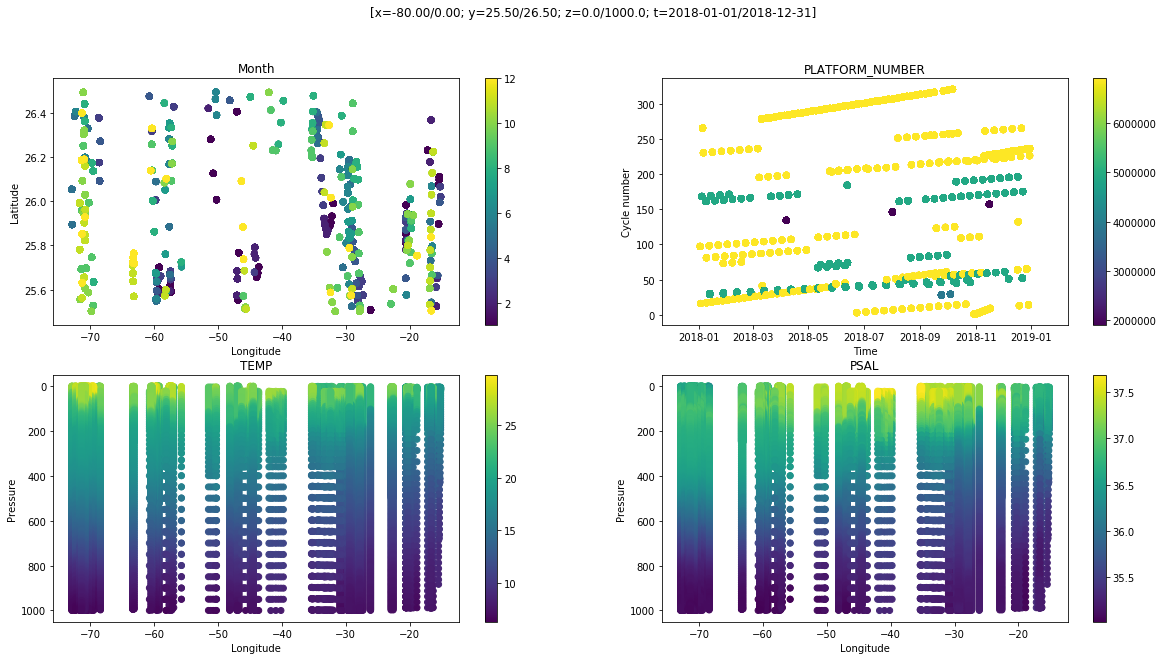

In [5]:
# Raw figure
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo['longitude'], argo['latitude'], c=argo['time.month'])
plt.colorbar(sc, ax=ax[ix])
ax[ix].set_xlabel('Longitude')
ax[ix].set_ylabel('Latitude')
ax[ix].set_title('Month')

ix += 1
sc = ax[ix].scatter(argo['time'].values, argo['CYCLE_NUMBER'], c=argo['PLATFORM_NUMBER'])
plt.colorbar(sc, ax=ax[ix])
ax[ix].set_xlabel('Time')
ax[ix].set_ylabel('Cycle number')
ax[ix].set_title('PLATFORM_NUMBER')

ix += 1
sc = ax[ix].scatter(argo['longitude'], argo['PRES'], c=argo['TEMP'])
plt.colorbar(sc, ax=ax[ix])
ax[ix].invert_yaxis()
ax[ix].set_xlabel('Longitude')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('TEMP')

ix += 1
sc = ax[ix].scatter(argo['longitude'], argo['PRES'], c=argo['PSAL'])
plt.colorbar(sc, ax=ax[ix])
ax[ix].invert_yaxis()
ax[ix].set_xlabel('Longitude')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('PSAL')

fig.suptitle(argo.attrs['Download_constraints']);

## Map of data around 200db depth for a single month

In [6]:
box = [-80., 0., 10., 65., 200-5., 200+5., '2018-01-01','2018-01-31']
argo = argo_loader.region(box).to_xarray(cache=1)
argo

<xarray.Dataset>
Dimensions:          (index: 4945)
Coordinates:
    time             (index) datetime64[ns] 2018-01-01T00:12:23 ... 2018-01-30T23:14:00
    latitude         (index) float64 50.08 63.98 24.17 ... 45.64 64.26 64.26
  * index            (index) int64 0 1 3 4 5 6 ... 5340 5341 5342 5343 5344 5345
    longitude        (index) float64 -12.57 -55.93 -35.44 ... -30.72 -30.72
Data variables:
    CYCLE_NUMBER     (index) float64 124.0 71.0 160.0 ... 131.0 134.0 134.0
    DATA_MODE        (index) <U1 'D' 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'R' 'R'
    DIRECTION        (index) <U1 'A' 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (index) int64 6901920 6901721 4901585 ... 6901566 6901566
    POSITION_QC      (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    PRES             (index) float64 199.7 196.0 196.0 ... 200.3 195.0 205.0
    PRES_ERROR       (index) float64 2.4 2.4 2.4 2.4 2.4 ... 2.4 2.4 2.4 nan nan
    PRES_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    PSAL             (index) float64 35.51 34.82 36.66 36.66 ... 35.7 34.9 34.91
    PSAL_ERROR       (index) float64 0.016 0.01842 0.01016 ... 0.01 nan nan
    PSAL_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    TEMP             (index) float64 11.52 5.491 18.61 ... 13.29 5.19 5.234
    TEMP_ERROR       (index) float64 0.002 0.002 0.002 0.002 ... 0.002 nan nan
    TEMP_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    TIME_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:               ARGO
    DOI:                   http://doi.org/10.17882/42182
    Downloaded_from:       http://www.ifremer.fr/erddap
    Downloaded_by:         gmaze
    Download_date:         2020/02/26
    Download_url:          http://www.ifremer.fr/erddap/tabledap/ArgoFloats.c...
    Download_constraints:  [x=-80.00/0.00; y=10.00/65.00; z=195.0/205.0; t=20...
    cache:                 cache/TSargo_28000_00000_01000_06500_01950_02050_2...
    history:               Variables selected according to DATA_MODE; Variabl...

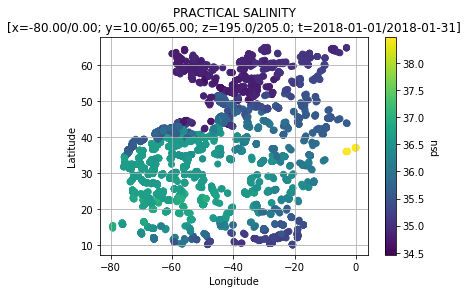

In [7]:
plt.scatter(argo['longitude'], argo['latitude'], c=argo['PSAL'])
plt.colorbar(label=argo['PSAL'].attrs['units'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().grid()
plt.title("%s\n%s" % (argo['PSAL'].attrs['long_name'], argo.attrs['Download_constraints']));

## Deployment over a region ?

In [8]:
# Retrieve all data for a region near the surface and a single month:
box = [-80., -45, 10, 45, 0, 10, '2018-01-01','2018-12-31']
argo = argo_loader.region(box).to_xarray()

# Then select only the first cycle number:
this = argo.where(argo['CYCLE_NUMBER']==1, drop=True)

# And group by WMOs:
this = this.reset_coords().groupby('PLATFORM_NUMBER').max()
this

/Users/gmaze/anaconda/envs/obidam36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<xarray.Dataset>
Dimensions:          (PLATFORM_NUMBER: 29)
Coordinates:
  * PLATFORM_NUMBER  (PLATFORM_NUMBER) float64 3.902e+06 3.902e+06 ... 6.901e+06
Data variables:
    CYCLE_NUMBER     (PLATFORM_NUMBER) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    DATA_MODE        (PLATFORM_NUMBER) object 'D' 'D' 'D' 'D' ... 'D' 'D' 'A'
    DIRECTION        (PLATFORM_NUMBER) object 'A' 'D' 'A' 'D' ... 'A' 'A' 'A'
    POSITION_QC      (PLATFORM_NUMBER) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    PRES             (PLATFORM_NUMBER) float64 10.0 10.0 10.0 ... 8.92 8.96 10.0
    PRES_ERROR       (PLATFORM_NUMBER) float64 2.4 2.4 2.4 2.4 ... 2.4 2.4 nan
    PRES_QC          (PLATFORM_NUMBER) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    PSAL             (PLATFORM_NUMBER) float64 36.52 36.82 36.91 ... 36.53 37.48
    PSAL_ERROR       (PLATFORM_NUMBER) float64 0.01 0.01 0.01 ... 0.01002 nan
    PSAL_QC          (PLATFORM_NUMBER) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    TEMP             (PLATFORM_NUMBER) float64 20.14 21.85 21.61 ... 24.16 26.19
    TEMP_ERROR       (PLATFORM_NUMBER) float64 0.002 0.002 0.002 ... 0.002 nan
    TEMP_QC          (PLATFORM_NUMBER) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    TIME_QC          (PLATFORM_NUMBER) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    time             (PLATFORM_NUMBER) datetime64[ns] 2018-04-17T05:47:00 ... 2018-11-07T12:04:51
    latitude         (PLATFORM_NUMBER) float64 34.0 32.47 32.99 ... 35.4 24.13
    longitude        (PLATFORM_NUMBER) float64 -54.97 -60.05 ... -73.67 -49.03

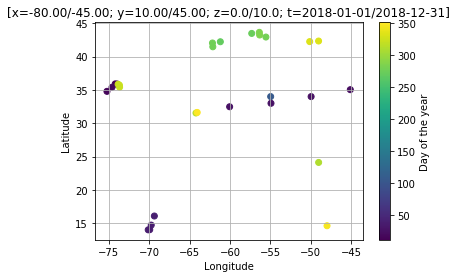

In [9]:
plt.scatter(this['longitude'], this['latitude'], c=this['time.dayofyear'])
plt.colorbar(label='Day of the year')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().grid()
plt.title("%s" % argo.attrs['Download_constraints']);

# Example of data fetching for a specific float

In [10]:
argo = argo_loader.float(6902746).to_xarray()
argo

<xarray.Dataset>
Dimensions:          (index: 9039)
Coordinates:
    time             (index) datetime64[ns] 2017-07-06T14:49:00 ... 2019-02-13T07:20:00
    latitude         (index) float64 20.08 20.08 20.08 20.08 ... 16.3 16.3 16.3
  * index            (index) int64 0 1 2 3 4 5 ... 9033 9034 9035 9036 9037 9038
    longitude        (index) float64 -60.17 -60.17 -60.17 ... -62.64 -62.64
Data variables:
    CYCLE_NUMBER     (index) float64 1.0 1.0 1.0 1.0 1.0 ... 84.0 84.0 84.0 84.0
    DATA_MODE        (index) <U1 'D' 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D' 'D'
    DIRECTION        (index) <U1 'D' 'D' 'D' 'D' 'D' 'D' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (index) int64 6902746 6902746 6902746 ... 6902746 6902746
    POSITION_QC      (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    PRES             (index) float64 9.0 14.0 24.0 ... 1.488e+03 1.509e+03
    PRES_ERROR       (index) float64 2.4 2.4 2.4 2.4 2.4 ... 2.4 2.4 2.4 2.4 2.4
    PRES_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    PSAL             (index) float64 36.06 36.06 36.06 ... 34.98 34.98 34.98
    PSAL_ERROR       (index) float64 0.01235 0.01236 0.01235 ... 0.04564 0.04565
    PSAL_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2 2 2
    TEMP             (index) float64 28.04 28.03 28.02 ... 4.286 4.281 4.277
    TEMP_ERROR       (index) float64 0.002 0.002 0.002 ... 0.002 0.002 0.002
    TEMP_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    TIME_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:               ARGO
    DOI:                   http://doi.org/10.17882/42182
    Downloaded_from:       http://www.ifremer.fr/erddap
    Downloaded_by:         gmaze
    Download_date:         2020/02/28
    Download_url:          http://www.ifremer.fr/erddap/tabledap/ArgoFloats.c...
    Download_constraints:  WMO6902746
    cache:                 tmp/TSargo_WMO6902746.nc
    history:               Variables selected according to DATA_MODE; Variabl...

In [11]:
# Get basic information about the float:
print('This float has performed: %i profiles' % len(np.unique(argo['CYCLE_NUMBER'])))
print('This float operated between %s and %s' % (argo['time'].min().values, argo['time'].max().values))
print('This float profiles range from %0.1fdb to %0.1fdb' % (argo['PRES'].min(), argo['PRES'].max() ))

This float has performed: 84 profiles
This float operated between 2017-07-06T14:49:00.000000000 and 2019-02-13T07:20:00.000000000
This float profiles range from 3.0db to 2032.0db


## Plot trajectory

Text(0.5, 1.0, 'WMO6902746')

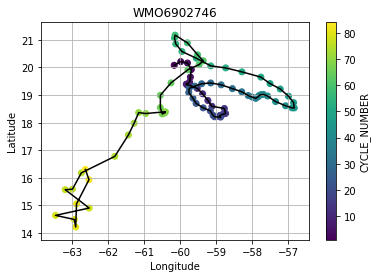

In [12]:
this = argo.reset_coords().groupby('CYCLE_NUMBER').min()
plt.plot(this['longitude'], this['latitude'], 'k-')
plt.scatter(this['longitude'], this['latitude'], c=this['CYCLE_NUMBER'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().grid()
plt.colorbar(label='CYCLE_NUMBER')
plt.title(argo.attrs['Download_constraints'])

## Water fall plots

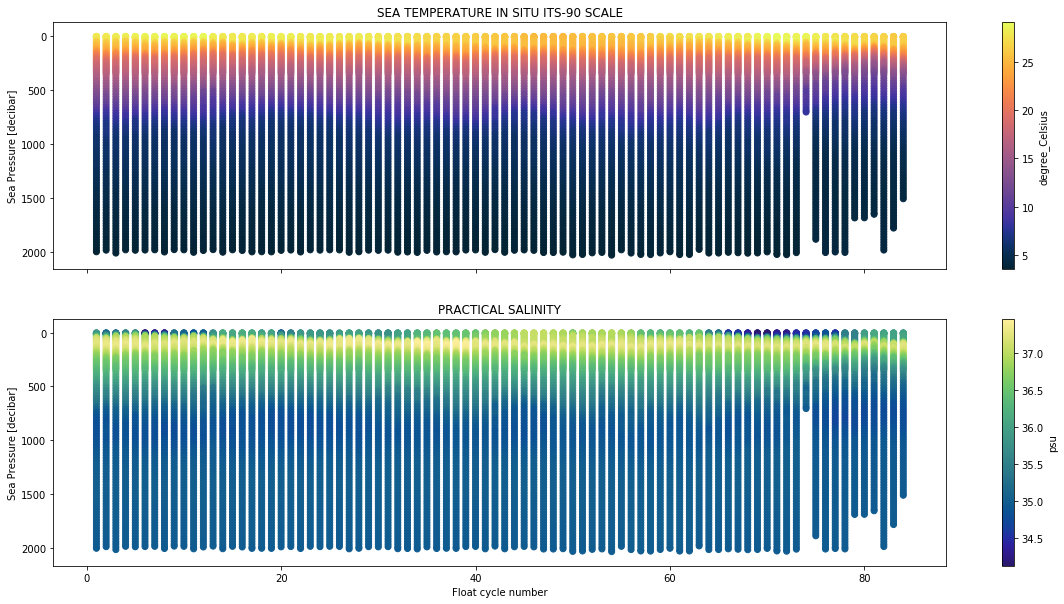

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,10), sharex=True, sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['TEMP'], cmap=cmocean.cm.thermal)
plt.colorbar(sc, ax=ax[ix], label=argo['TEMP'].attrs['units'])
ax[ix].invert_yaxis()
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['PSAL'], cmap=cmocean.cm.haline)
plt.colorbar(sc, ax=ax[ix], label=argo['PSAL'].attrs['units'])
# ax[ix].invert_yaxis()
ax[ix].set_xlabel(argo['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['PSAL'].attrs['long_name']);


## Super-imposed profiles

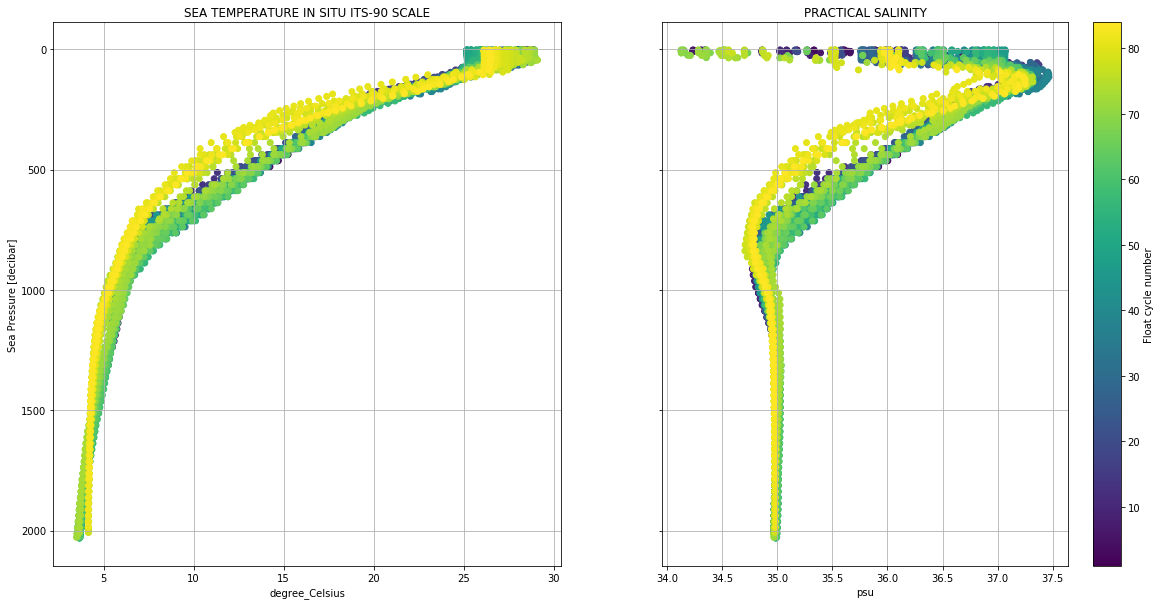

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo['TEMP'], argo['PRES'], c=argo['CYCLE_NUMBER'])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel(argo['TEMP'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo['PSAL'], argo['PRES'], c=argo['CYCLE_NUMBER'])
plt.colorbar(sc, ax=ax[ix], label=argo['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].grid()
ax[ix].set_xlabel(argo['PSAL'].attrs['units'])
ax[ix].set_title(argo['PSAL'].attrs['long_name']);


## T/S diagram

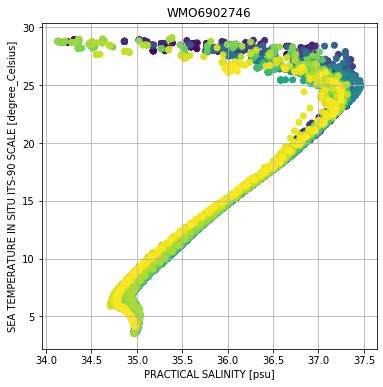

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
ax = np.array(ax).flatten()
ix = 0
sc = ax[ix].scatter(argo['PSAL'], argo['TEMP'], c=argo['CYCLE_NUMBER'])
ax[ix].grid()
ax[ix].set_xlabel("%s [%s]" % (argo['PSAL'].attrs['long_name'], argo['PSAL'].attrs['units']))
ax[ix].set_ylabel("%s [%s]" % (argo['TEMP'].attrs['long_name'], argo['TEMP'].attrs['units']))
plt.title(argo.attrs['Download_constraints']);

# Example of data fetching for a specific profile

In [16]:
argo = argo_loader.profile(6902746, 12).to_xarray()
argo

<xarray.Dataset>
Dimensions:          (index: 108)
Coordinates:
    time             (index) datetime64[ns] 2017-09-01T06:53:00 ... 2017-09-01T06:53:00
    latitude         (index) float64 18.8 18.8 18.8 18.8 ... 18.8 18.8 18.8 18.8
  * index            (index) int64 0 1 2 3 4 5 6 ... 101 102 103 104 105 106 107
    longitude        (index) float64 -59.24 -59.24 -59.24 ... -59.24 -59.24
Data variables:
    CYCLE_NUMBER     (index) float64 12.0 12.0 12.0 12.0 ... 12.0 12.0 12.0 12.0
    DATA_MODE        (index) <U1 'D' 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D' 'D'
    DIRECTION        (index) <U1 'A' 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (index) int64 6902746 6902746 6902746 ... 6902746 6902746
    POSITION_QC      (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    PRES             (index) float64 3.0 4.0 5.0 ... 1.963e+03 1.989e+03
    PRES_ERROR       (index) float64 2.4 2.4 2.4 2.4 2.4 ... 2.4 2.4 2.4 2.4 2.4
    PRES_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    PSAL             (index) float64 35.02 35.03 35.03 ... 34.99 34.99 34.99
    PSAL_ERROR       (index) float64 0.01 0.01 0.01 0.01 ... 0.01 0.01 0.01 0.01
    PSAL_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    TEMP             (index) float64 28.9 28.9 28.9 28.89 ... 3.771 3.734 3.693
    TEMP_ERROR       (index) float64 0.002 0.002 0.002 ... 0.002 0.002 0.002
    TEMP_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    TIME_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:               ARGO
    DOI:                   http://doi.org/10.17882/42182
    Downloaded_from:       http://www.ifremer.fr/erddap
    Downloaded_by:         gmaze
    Download_date:         2020/02/28
    Download_url:          http://www.ifremer.fr/erddap/tabledap/ArgoFloats.c...
    Download_constraints:  WMO6902746_CYC0012
    cache:                 tmp/TSargo_WMO6902746_CYC0012.nc
    history:               Variables selected according to DATA_MODE; Variabl...

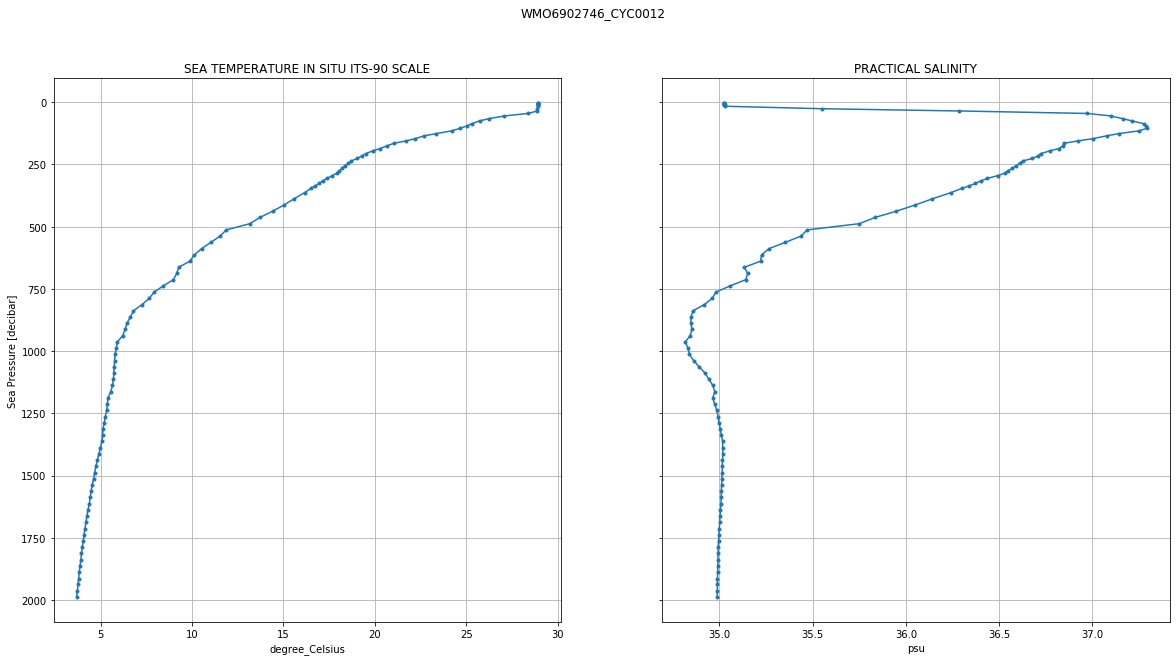

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True)
ax = np.array(ax).flatten()

ix = 0
ax[ix].plot(argo['TEMP'], argo['PRES'], '.-')
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel(argo['TEMP'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['TEMP'].attrs['long_name'])

ix += 1
ax[ix].plot(argo['PSAL'], argo['PRES'], '.-')
ax[ix].grid()
ax[ix].set_xlabel(argo['PSAL'].attrs['units'])
ax[ix].set_title(argo['PSAL'].attrs['long_name']);

fig.suptitle(argo.attrs['Download_constraints']);